# Test cases to convert arbitrary flux values into hourly values

In [1]:
import numpy as np
import pandas as pd
from scipy import integrate
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

In [ ]:
import sys
import datetime
import pandas as pd
import xarray as xr
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import python_cs_functions as cs

### Functions

In [6]:
# Fill gaps with temporary values where needed
def fill_data_gaps_on_integration_bounds(df, data='data', center_window=True):
    
    for ix,(time,row) in enumerate(df.iterrows()):

        # Missing value at a given point in time
        if np.isnan(row[data]): 

            # Only proceed if this is a timestamp that we'll need as a boundary value for volume integration
            if ((center_window) & (time.minute == 30)) or \
            ((not center_window)& (time.minute == 0)):

                # Check if we have any valid values in the past and/or next hour
                prev_time_mask = slice(time - timedelta(hours=1),time) # Returns empty series if time slice is out of index range
                prev_data_mask = (df[data].loc[prev_time_mask] >= 0) & \
                                 (df['is_obs'].loc[prev_time_mask]) # Has data and is observation (i.e. not previously filled value)
                next_time_mask = slice(time, time + timedelta(hours=1))
                next_data_mask = (df[data].loc[next_time_mask] >= 0) & \
                                 (df['is_obs'].loc[next_time_mask])

                # Select the correct case
                if any(prev_data_mask) and any(next_data_mask):
                    # do nothing: we'll interpolate the missing value later
                    continue # to next row in the dataframe
                elif any(prev_data_mask):
                    # Copy closest value from the previous hour into this position
                    df.at[time,data] = df[prev_time_mask][prev_data_mask].iloc[-1][data]
                elif any(next_data_mask):
                    # Copy the closest value from the next hour into this position
                    df.at[time,data] = df[next_time_mask][next_data_mask].iloc[-1][data]
                else:
                    # do nothing: we don't have observations from either the previous or the next hour, so we'll leave this empty
                    continue # to next row in the dataframe
    
    return df

In [55]:
def resample_arbitrary_flux_observations_to_hourly(df, data='data', center_window=True):
    
    '''Takes a dataframe with a timestamp index and a "data" column and returns old and new dataframe with hourly data values'''
    
    # Inputs:
    # df            - dataframe with a column with name [data]
    # data          - column name; default 'data'
    # center_window - flag to state if hourly resampling should take the whole hour as the mid-point of the window
    #                 (e.g. if the value for 12:00 should be based on [True] 11:30-12:30; or [False] on 12:00-13:00)
    
    # Copy the input dataframe so we don't change it outside this function
    df = df.copy()
    
    # Ensure we have values at every half hour, so that resampling works properly
    half_hour_start = df.index[0].ceil('30min') # round up to the nearest half hour, so that we can safely interpolate
    half_hour_end   = df.index[-1].floor('30min') # round down to nearest half hour so we only interpolate between observations
    half_hour_times = pd.date_range(half_hour_start,half_hour_end, freq='30min') # Adding 30 minute intervals means this works 
                                                                                 #    with both center_window settings
    
    # Insert the new times into the old dataframe
    df['is_obs'] = 1 # Add a new column that flags the original observations, so we know what was interpolated later on
    tmp_df = pd.DataFrame(index=half_hour_times) # automatically puts in NaNs for data
    df = pd.concat([df,tmp_df], axis=1) # automatically gives us NaNs in places where we don't have 'data' values
    
    # Attempt to fill gaps on the left-hand and right-hand side of the integration windows, where gaps longer than 1h exist
    #  between actual observed values. We don't want to use interpolated values here because they might be too far off reality
    df = fill_data_gaps_on_integration_bounds(df, data=data, center_window=center_window)
    
    # Interpolate the missing values
    df[data] = df[data].interpolate(method='time', limit_area='inside') # only interpolate between valid values
    
    # Get an x-axis for integration in seconds
    df['time_diff_in_sec'] = (df.index - df.index[0]).astype('timedelta64[s]')
    
    # Convert all arrays from shape (n,) to (1,n), so we can use np.hstack() later
    # left side of interval
    x1 = df['time_diff_in_sec'].values.reshape(-1,1)
    y1 = df[data].values.reshape(-1,1)
    
    # right side of interval: shift entire array by 1 timestep, to get the consectuive values for everything 
    # in x1 and x2 at the same indices as x1 and y1 use
    y2 = df[data].shift(periods=-1).values.reshape(-1,1) 
    x2 = df['time_diff_in_sec'].shift(periods=-1).values.reshape(-1,1)
    
    # stick paired values side-by-side, so we have each pair of consecutive values as a single entry
    x = np.hstack([x1,x2])
    y = np.hstack([y1,y2])
    
    # Integrate to find volumes between current timestamps
    df['volume_between_now_and_next'] = integrate.trapezoid(y,x=x)
    
    # Resample to hourly using the whole hour as a mid-point
    if center_window:
        #  Source: https://stackoverflow.com/questions/59948078/resample-to-pandas-dataframe-to-hourly-using-hour-as-mid-point
        #  This shifts the entire time index by 30 minutes, meaning what was previously 11.30 is now 12.00
        #  Because pandas.resample() operates on whole hours, it will with this new index therefore be working with the
        #  data from 11.30-12.30, even though the new index would list times between 12.00-13.00. One extra benefit of
        #  this is that the resampled data will automatically be associated with the correct mid-point time (e.g. 12.00).
        df_H = df.shift(freq='30min').resample('1H').sum()
    else:
        df_H = df.resample('1H').sum()
    
    # Convert volume back into flux
    df_H[data] = df_H['volume_between_now_and_next'] / 3600
    
    # CLEAN-UP
    # Remove the interpolated values that are not based on any observations
    df_H.loc[df_H['is_obs'] == 0, data] = np.nan
    
    # Account for ICE data values
    # < TO DO: needs to come earlier than here >
    
    # Remove the temporary columns in the hourly dataframe
    df_H = df_H.drop(['time_diff_in_sec','volume_between_now_and_next'], axis=1)
    
    return df, df_H

## Test cases 
Assumptions:
1. For the time series as a whole, we don't want to extrapolate to times before the first observation, nor extrapolate to times beyond the last 0bservation.
2. We want mean hourly flow rates, with a window centered on the whole hour (i.e., the value for `12:00` is based on any observations within the `11:30` - `12:30` window).
3. If we have no observations for a given hour, we don't want an hourly mean flow rate for that hour either.

### Test case 0 - why do a volume preserving approach?
Instantaneous values are only valid at the point in time that they are taken. By estimating the progression of the hydrograph between IV measurements, integrating between these estimates to find the volume of water that passed during a given window, and dividing by the window size we get an estimate of the average flow rate over the window. 

The downside of this approach is that the actual measured values are lost. See figure where the IV values go up and down, but the average flow (blue) steadily goes up.

In [2]:
time = [pd.to_datetime('2000-01-01 11:00'),
        pd.to_datetime('2000-01-01 12:00'),
        pd.to_datetime('2000-01-01 13:00'),
        pd.to_datetime('2000-01-01 14:00'),
        pd.to_datetime('2000-01-01 15:00')]
data = np.array([0,2,1,4,2])
df0  = pd.DataFrame({'time': time, 'data': data})
df0  = df0.set_index('time')

In [3]:
df0['resample_mean'] = df0.resample('1H').mean()

In [4]:
df0['time_diff_in_sec'] = (df0.index - df0.index[0]).astype('timedelta64[s]')

x1 = df0['time_diff_in_sec'].values.reshape(-1,1)
y1 = df0['data'].values.reshape(-1,1)
y2 = df0['data'].shift(periods=-1).values.reshape(-1,1) 
x2 = df0['time_diff_in_sec'].shift(periods=-1).values.reshape(-1,1)

x = np.hstack([x1,x2])
y = np.hstack([y1,y2])
    
df0['volume_between_now_and_next'] = integrate.trapezoid(y,x=x)

df0['integrate_mean'] = df0['volume_between_now_and_next'] / 3600

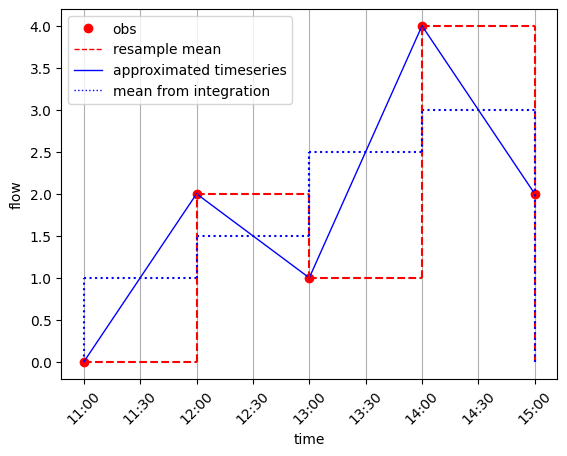

In [5]:
fig,ax = plt.subplots(1,1)
ax.plot(df0['data'], marker='o', markeredgecolor='r',markerfacecolor='r',linestyle='')

# horizontal lines
for ix in range(len(df0)-1):
    plt.plot_date([df0.iloc[ix].name, df0.iloc[ix+1].name],
                  [df0.iloc[ix].resample_mean, df0.iloc[ix].resample_mean], fmt='--', color='r')
    plt.plot_date([df0.iloc[ix].name, df0.iloc[ix+1].name],
                  [df0.iloc[ix].data, df0.iloc[ix+1].data], fmt='-', color='b', lw=1)
    plt.plot_date([df0.iloc[ix].name, df0.iloc[ix+1].name],
                  [df0.iloc[ix].integrate_mean, df0.iloc[ix].integrate_mean], fmt=':', color='b')

# vertical lines
for ix in range(len(df0)):
    if ix == 0: # left edge
        plt.plot_date([df0.iloc[ix].name, df0.iloc[ix].name], [0, df0.iloc[ix].resample_mean], fmt='--', color='r')
        plt.plot_date([df0.iloc[ix].name, df0.iloc[ix].name], [0, df0.iloc[ix].integrate_mean], fmt=':', color='b')
    elif ix == len(df0)-1: # right edge
        plt.plot_date([df0.iloc[ix].name, df0.iloc[ix].name], [0, df0.iloc[ix-1].resample_mean], fmt='--', color='r')
        plt.plot_date([df0.iloc[ix].name, df0.iloc[ix].name], [0, df0.iloc[ix-1].integrate_mean], fmt=':', color='b')
    else: # middle sections
        plt.plot_date([df0.iloc[ix].name, df0.iloc[ix].name],
                      [df0.iloc[ix-1].resample_mean, df0.iloc[ix].resample_mean], fmt='--', color='r')
        plt.plot_date([df0.iloc[ix+1].name, df0.iloc[ix+1].name],
                      [df0.iloc[ix].resample_mean, df0.iloc[ix].resample_mean], fmt='--', color='r')
        plt.plot_date([df0.iloc[ix].name, df0.iloc[ix].name],
                      [df0.iloc[ix-1].integrate_mean, df0.iloc[ix].integrate_mean], fmt=':', color='b')
        plt.plot_date([df0.iloc[ix+1].name, df0.iloc[ix+1].name],
                      [df0.iloc[ix].integrate_mean, df0.iloc[ix+1].integrate_mean], fmt=':', color='b')
    
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)

ax.grid(axis='x');
plt.xticks(rotation=45);
plt.xlabel('time');
plt.ylabel('flow');

legend_elements = [Line2D([0], [0], marker='o', markeredgecolor='r',markerfacecolor='r',linestyle='', label='obs'),
                   Line2D([0], [0], color='r', linestyle='--', lw=1, label='resample mean'),
                   Line2D([0], [0], color='b', linestyle='-',  lw=1, label='approximated timeseries'),
                   Line2D([0], [0], color='b', linestyle=':', lw=1, label='mean from integration')
                   ]
plt.legend(handles=legend_elements);

### Test case 1 - regularly spaced data, data start at 11.30, no gaps

In [8]:
# Create a test df
date_s = pd.to_datetime('2000-01-01 11:30')
date_e = date_s + timedelta(hours=1)
hours = pd.date_range(date_s, date_e, freq='15min')
data  = np.array([3,4,3,1,0])
df1 = pd.DataFrame({'time': hours, 'data': data})
df1 = df1.set_index('time')

In [9]:
df1_o, df1_H = resample_arbitrary_flux_observations_to_hourly(df1)

In [10]:
# Compare against known (manual) solutions:
# 1. We have 5 timestamps and thus 4 integrals between these.
# 2. The integrals are in order: 3150, 3150, 1800, 450 // These shuld be in the 'volume_between_now_and_next' column of df1_o
# 3. The integrals sum to: 8550 // This should be in the 'volume_between_now_and_next' column of df1_H
# 4. We will get an extra final entry in both df1_o and df1_H, which we can ignore. These entries fill in space in the dataframe
#    behind the final timestamp, i.e. the most right-hand value of the integrals. This will have been used to compute integral 4
assert (df1_o['volume_between_now_and_next'].values[:-1] == np.array([3150,3150,1800,450])).all()
assert (df1_H['volume_between_now_and_next'].values[0]   == 8550)

In [11]:
df1

,data
time,
2000-01-01 11:30:00,3
2000-01-01 11:45:00,4
2000-01-01 12:00:00,3
2000-01-01 12:15:00,1
2000-01-01 12:30:00,0


In [12]:
df1_o

,data,is_obs,time_diff_in_sec,volume_between_now_and_next
2000-01-01 11:30:00,3,1,0.0,3150.0
2000-01-01 11:45:00,4,1,900.0,3150.0
2000-01-01 12:00:00,3,1,1800.0,1800.0
2000-01-01 12:15:00,1,1,2700.0,450.0
2000-01-01 12:30:00,0,1,3600.0,NaN


In [13]:
df1_H

,data,is_obs,time_diff_in_sec,volume_between_now_and_next
2000-01-01 12:00:00,2.375,4,5400.0,8550.0
2000-01-01 13:00:00,0.000,1,3600.0,0.0


### Test case 2 - regularly spaced data, data start at 11.45, no gaps
We'll create a similar dataframe to test case 1 but longer, which we'll use to compare the outcomes of the second dataframe to. The first hour should be different, the other hours should be the same.

In [14]:
# Create a baseline df
date_s = pd.to_datetime('2000-01-01 11:30')
date_e = date_s + timedelta(hours=5)
hours = pd.date_range(date_s, date_e, freq='15min')
data  = np.array([3,4,3,1,0,3,4,3,1,0,3,4,3,1,0,3,4,3,1,0,3])
df2_base = pd.DataFrame({'time': hours, 'data': data})
df2_base = df2_base.set_index('time')

In [15]:
# Create a test dataframe by removing the first entry of the baseline df
df2_test = df2_base.iloc[1:].copy()

In [16]:
_,df2_base_H = resample_arbitrary_flux_observations_to_hourly(df2_base)
_,df2_test_H = resample_arbitrary_flux_observations_to_hourly(df2_test)

In [17]:
# Compare known solutions:
# 1. We know all but the first entry 
assert (df2_base_H['data'].values[1:] == df2_test_H['data'].values[1:]).all()

In [18]:
df2_base_H

,data,is_obs,time_diff_in_sec,volume_between_now_and_next
2000-01-01 12:00:00,2.375,4,5400.0,8550.0
2000-01-01 13:00:00,2.625,4,19800.0,9450.0
2000-01-01 14:00:00,2.250,4,34200.0,8100.0
2000-01-01 15:00:00,1.875,4,48600.0,6750.0
2000-01-01 16:00:00,1.875,4,63000.0,6750.0
2000-01-01 17:00:00,0.000,1,18000.0,0.0


In [19]:
df2_test_H

,data,is_obs,time_diff_in_sec,volume_between_now_and_next
2000-01-01 12:00:00,1.500,3,2700.0,5400.0
2000-01-01 13:00:00,2.625,4,16200.0,9450.0
2000-01-01 14:00:00,2.250,4,30600.0,8100.0
2000-01-01 15:00:00,1.875,4,45000.0,6750.0
2000-01-01 16:00:00,1.875,4,59400.0,6750.0
2000-01-01 17:00:00,0.000,1,17100.0,0.0


### Test case 3 - irregularly space data, no gaps
This is intended to check two things:
1. Does the approach work with irregularly spaced data?
2. Does the approach work if we don't have observations on the precise moments that are the left and right-hand side of the hourly intervals we want to convert to?

In [21]:
time = [pd.to_datetime('2000-01-01 11:30'),
        pd.to_datetime('2000-01-01 11:40'),
        pd.to_datetime('2000-01-01 11:57'),
        pd.to_datetime('2000-01-01 12:03'),
        pd.to_datetime('2000-01-01 12:35')]
data = np.array([0,2,1,4,2])
df3  = pd.DataFrame({'time': time, 'data': data})
df3  = df3.set_index('time')

In [22]:
df3_o,df3_H = resample_arbitrary_flux_observations_to_hourly(df3)

In [23]:
# Compare against known (manual) solutions:
# 1. We have 5 timestamps and will add 2 (12:00, 12:30) and thus will have 6 integrals between these.
# 2. The integrals are in order: 600, 1530, 315, 585, 5113.125, 646.875 // 'volume_between_now_and_next' column of df3_o
# 3. The integrals sum to: 8143.125 // This should be in the 'volume_between_now_and_next' column of df3_H
# 4. We will get an extra final entry in both df1_o and df1_H, which we can ignore. These entries fill in space in the dataframe
#    behind the final timestamp, i.e. the most right-hand value of the integrals. This will have been used to compute integral 4
assert (df3_o['volume_between_now_and_next'].values[:-1] == np.array([600,1530,315,585,5113.125,646.875])).all()
assert (df3_H['volume_between_now_and_next'].values[0]   == 8143.125)

In [24]:
df3

,data
time,
2000-01-01 11:30:00,0
2000-01-01 11:40:00,2
2000-01-01 11:57:00,1
2000-01-01 12:03:00,4
2000-01-01 12:35:00,2


In [25]:
df3_o

,data,is_obs,time_diff_in_sec,volume_between_now_and_next
2000-01-01 11:30:00,0.0000,1.0,0.0,600.000
2000-01-01 11:40:00,2.0000,1.0,600.0,1530.000
2000-01-01 11:57:00,1.0000,1.0,1620.0,315.000
2000-01-01 12:00:00,2.5000,NaN,1800.0,585.000
2000-01-01 12:03:00,4.0000,1.0,1980.0,5113.125
2000-01-01 12:30:00,2.3125,NaN,3600.0,646.875
2000-01-01 12:35:00,2.0000,1.0,3900.0,NaN


In [26]:
df3_H

,data,is_obs,time_diff_in_sec,volume_between_now_and_next
2000-01-01 12:00:00,2.261979,4.0,6000.0,8143.125
2000-01-01 13:00:00,0.179688,1.0,7500.0,646.875


### Test case 4 - irregularly space data, gaps
We want to retain the gaps if we have no observations for a given hour, so that we don't create a false sense of security in our interpolated data. This can only occur if we have no observations on the left and right-hand side of the hourly interval (e.g. 11.30 and 12.30), and nothing in between those. 

A second question brought up by such a case is how to handle cases where we have no value at the left or right-hand side of the hourly interval, and nothing to use for interpolation with an earlier value. For example (`time`: `data`):
- 10.30: 1
- 11.00: `to be determined`
- 11.15: 1
- 11.30: n/a
- 12.00: `to be determined`
- 12.30: n/a
- 12.45: 10
- 13.00: `to be determined`
- 13.30: 10

In this case we cannot determine a value for `12.00` because there is no single data point within that interval. To handle the other cases (right-hand side of the `11.00` value, and left-hand side of the `13.00` value), we'll extend the respective values forward and backward as the safest option. 

In [27]:
time = [pd.to_datetime('2000-01-01 10:30'),
        pd.to_datetime('2000-01-01 11:15'), # Data gap: no observations within the 11:30-12:30 window
        pd.to_datetime('2000-01-01 12:45'),
        pd.to_datetime('2000-01-01 13:30')] 
data = np.array([1,1,10,10])
df4  = pd.DataFrame({'time': time, 'data': data})
df4  = df4.set_index('time')

In [28]:
df4_o,df4_H = resample_arbitrary_flux_observations_to_hourly(df4)

In [29]:
# Compare against known (manual) solutions:
# 1. We have 4 timestamps and will add 5 more (11:00, 11:30, 12:00, 12:30, 13:00) for a total of 11
# 2. We want to end up with the following mean hourly flows: [11:00 - 1.0], [12:00 - undefined], [13:00 - 10.0]
assert df4_H['data'].values[0] == 1
assert np.isnan(df4_H['data'].values[1]) # NaN == NaN is False by definition, so need to use a dedicated function to checl
assert df4_H['data'].values[2] == 10

In [30]:
df4

,data
time,
2000-01-01 10:30:00,1
2000-01-01 11:15:00,1
2000-01-01 12:45:00,10
2000-01-01 13:30:00,10


In [31]:
df4_o

,data,is_obs,time_diff_in_sec,volume_between_now_and_next
2000-01-01 10:30:00,1.0,1.0,0.0,1800.0
2000-01-01 11:00:00,1.0,NaN,1800.0,900.0
2000-01-01 11:15:00,1.0,1.0,2700.0,900.0
2000-01-01 11:30:00,1.0,NaN,3600.0,5850.0
2000-01-01 12:00:00,5.5,NaN,5400.0,13950.0
2000-01-01 12:30:00,10.0,NaN,7200.0,9000.0
2000-01-01 12:45:00,10.0,1.0,8100.0,9000.0
2000-01-01 13:00:00,10.0,NaN,9000.0,18000.0
2000-01-01 13:30:00,10.0,1.0,10800.0,NaN


In [32]:
df4_H

,data,is_obs,time_diff_in_sec,volume_between_now_and_next
2000-01-01 11:00:00,1.0,2.0,4500.0,3600.0
2000-01-01 12:00:00,NaN,0.0,9000.0,19800.0
2000-01-01 13:00:00,10.0,1.0,24300.0,36000.0
2000-01-01 14:00:00,0.0,1.0,10800.0,0.0


### Test case 5 - data gaps, with the single hourly value on the right-hand side of the summing interval
In this case, we do want to keep the estimated hourly flow rate because there is at least one valid value in the interval (even if it is as far right on the interval as possible). 

In [63]:
time = [pd.to_datetime('2000-01-01 10:30'),
        pd.to_datetime('2000-01-01 11:15'), # Data gap: no observations within the 11:30-12:30 window
        pd.to_datetime('2000-01-01 12:30')]
data = np.array([1,1,10])
df5  = pd.DataFrame({'time': time, 'data': data})
df5  = df5.set_index('time')

In [66]:
df5_o, df5_H = resample_arbitrary_flux_observations_to_hourly(df5)

In [64]:
df5

,data
time,
2000-01-01 10:30:00,1
2000-01-01 11:15:00,1
2000-01-01 12:30:00,10


In [67]:
df5_o

,data,is_obs,time_diff_in_sec,volume_between_now_and_next
2000-01-01 10:30:00,1.0,1.0,0.0,1800.0
2000-01-01 11:00:00,1.0,NaN,1800.0,900.0
2000-01-01 11:15:00,1.0,1.0,2700.0,1710.0
2000-01-01 11:30:00,2.8,NaN,3600.0,8280.0
2000-01-01 12:00:00,6.4,NaN,5400.0,14760.0
2000-01-01 12:30:00,10.0,1.0,7200.0,NaN


In [68]:
df5_H

,data,is_obs
2000-01-01 11:00:00,1.225,2.0
2000-01-01 12:00:00,NaN,0.0
2000-01-01 13:00:00,0.000,1.0


### Test case 6 - real data

In [33]:
data_path = 'C:/Globus endpoint/CAMELS_spat/camels-spat-data/basin_data/USA_14400000/observations/USA_14400000_flow_observations_raw.csv'

In [46]:
# Read only the columns we need (time and obs)
raw = pd.read_csv(data_path, index_col=0, parse_dates=True, usecols=['tz_datetime','obs_00060'])

In [53]:
raw_o,raw_H = resample_arbitrary_flux_observations_to_hourly(raw, data='obs_00060')

In [54]:
raw_H

,obs_00060,is_obs,time_diff_in_sec,volume_between_now_and_next
1988-10-01 08:00:00,77.00,2.0,1.800000e+03,277200.0
1988-10-01 09:00:00,76.50,2.0,9.000000e+03,275400.0
1988-10-01 10:00:00,75.00,2.0,1.620000e+04,270000.0
1988-10-01 11:00:00,75.00,2.0,2.340000e+04,270000.0
1988-10-01 12:00:00,75.00,2.0,3.060000e+04,270000.0
...,...,...,...,...
2023-01-03 04:00:00,4260.00,4.0,4.324095e+09,15336000.0
2023-01-03 05:00:00,4258.75,4.0,4.324109e+09,15331500.0
2023-01-03 06:00:00,4218.75,4.0,4.324124e+09,15187500.0
2023-01-03 07:00:00,4150.00,4.0,4.324138e+09,14940000.0


<Axes: >

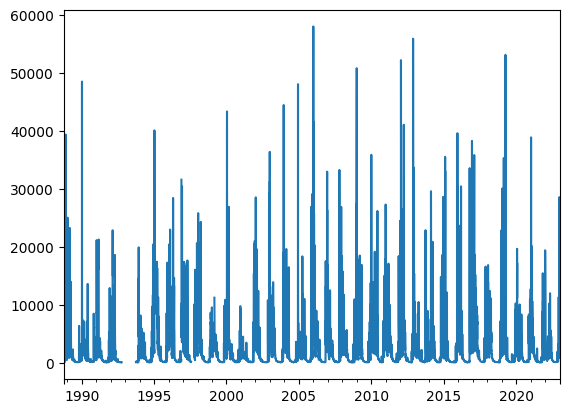

In [58]:
raw_H['obs_00060'].plot()

<Axes: xlabel='tz_datetime'>

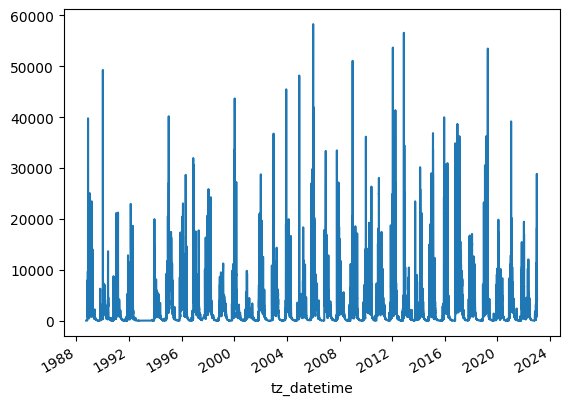

In [59]:
raw['obs_00060'].plot()